In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [34]:
# data downloading
data_df = pd.read_excel('/content/drive/MyDrive/Test_task/Data2.xlsx')

In [16]:
data_df.head()

,user_id,event_timestamp,first_purchase_time,cohort_week,lifetime_weeks,product_id
0,6f8592c0-fb4c-47dc-9344-424eb5d88a4b,2023-10-13 09:54:01.505,2023-10-13 09:54:01.728,2023-10-08 09:54:01.728,0,weekly.2.49
1,95287b91-85af-4174-9986-aeafb3853bb6,2023-10-14 04:45:13.909,2023-03-25 04:44:40.416,2023-03-19 04:44:40.416,29,weekly.2.49
2,95287b91-85af-4174-9986-aeafb3853bb6,2023-03-25 04:44:40.072,2023-03-25 04:44:40.416,2023-03-19 04:44:40.416,0,weekly.2.49
3,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-01 04:44:16.295,2023-03-25 04:44:40.416,2023-03-19 04:44:40.416,1,weekly.2.49
4,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-08 04:45:55.419,2023-03-25 04:44:40.416,2023-03-19 04:44:40.416,2,weekly.2.49


In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6086 entries, 0 to 6085
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              6086 non-null   object        
 1   event_timestamp      6086 non-null   datetime64[ns]
 2   first_purchase_time  6086 non-null   datetime64[ns]
 3   cohort_week          6086 non-null   datetime64[ns]
 4   lifetime_weeks       6086 non-null   int64         
 5   product_id           6086 non-null   object        
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 285.4+ KB


# Preparation and calculations

In [18]:
data_df['cohort_week'] = data_df['cohort_week'].dt.isocalendar().week

In [19]:
data_df['purchase_value'] = data_df['product_id'].str.extract(r'(\d+\.\d+)', expand=False).astype(float)

In [20]:
data_df['purchase_value']

0       2.49
1       2.49
2       2.49
3       2.49
4       2.49
        ... 
6081    2.49
6082    2.49
6083    2.49
6084    2.49
6085    2.49
Name: purchase_value, Length: 6086, dtype: float64

In [22]:
user_lifetime_value = data_df.groupby(['user_id', 'cohort_week']).agg(
    total_spend=('purchase_value', 'sum'),
    lifetime_weeks=('lifetime_weeks', 'max')
).reset_index()

In [23]:
user_lifetime_value

,user_id,cohort_week,total_spend,lifetime_weeks
0,00026e14-e302-4772-b691-8b0e67ab0c32,22,49.80,19
1,0047993c-3cff-4ab4-a34a-e376f823c282,11,2.49,0
2,00f7a8b6-9dd5-4806-bc31-69c8bc68bb24,15,2.49,0
3,0124f243-d4d0-4971-b997-1e6b79c866f0,14,7.47,4
4,0126e40c-da09-4e28-b687-457716e6ccfd,9,2.49,0
...,...,...,...,...
929,fec8b6a1-1bfc-49af-bc87-69679149945f,16,2.49,0
930,fee872ce-acb6-4c1d-ab31-c817b5867577,22,2.49,0
931,feeca102-8532-458d-bb51-7883f3f9a761,11,17.43,7
932,ff9a70ec-9962-4378-9fab-011780499257,8,39.84,32


# Calculation of the average LTV in cohorts

In [24]:
avg_ltv_per_cohort = user_lifetime_value.groupby('cohort_week').agg(avg_ltv=('total_spend', 'mean')).reset_index()

In [25]:
avg_ltv_per_cohort

,cohort_week,avg_ltv
0,8,20.418000
1,9,18.080795
2,10,17.646522
3,11,16.807500
4,12,18.675000
5,13,17.015000
6,14,20.325349
7,15,12.450000
8,16,12.747313
9,17,17.173676


# Data preparation

In [26]:
x = avg_ltv_per_cohort[['cohort_week']]
y = avg_ltv_per_cohort['avg_ltv']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Training

In [27]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

# Prediction and assesment

In [28]:
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# LTV prediction for 1 year and visualization

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


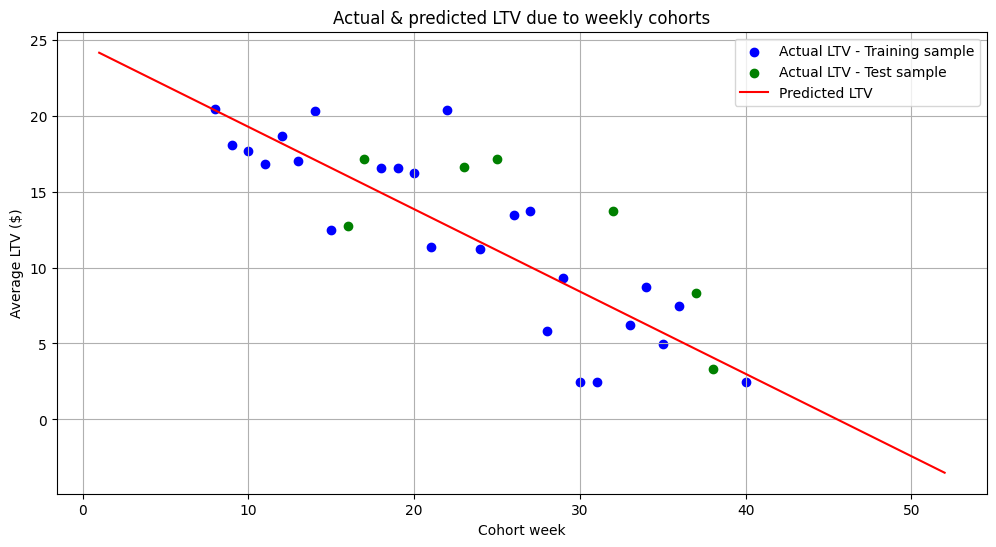

MAE: 3.7343089356675443
RMSE: 4.1952210034937245


In [35]:
cohort_weeks = np.arange(1, 53).reshape(-1, 1) # (52 тижні ~ 1 рік)
predicted_ltv = model.predict(cohort_weeks)

plt.figure(figsize=(12, 6))
plt.scatter(x_train, y_train, color='blue', label='Actual LTV - Training sample')
plt.scatter(x_test, y_test, color='green', label='Actual LTV - Test sample')
plt.plot(cohort_weeks, predicted_ltv, color='red', label='Predicted LTV')
plt.xlabel('Cohort week')
plt.ylabel('Average LTV ($)')
plt.title('Actual & predicted LTV due to weekly cohorts')
plt.legend()
plt.grid(True)
plt.show()

print("MAE:", mae)
print("RMSE:", rmse)